# 統計学をpythonで実践

## ○サンプルデータの準備

In [81]:
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# seabornのサンプルデータの準備。https://github.com/mwaskom/seaborn-data
# githubのtips.csvをロード
# あるレストランで支払われたチップに関するデータ
df = sns.load_dataset('tips')

# 支払額とチップの割合のカラムを追加
df['tip_rate'] = df['tip'] / df['total_bill']
df

,total_bill,tip,sex,smoker,day,time,size,tip_rate
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Male,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,Male,No,Sat,Dinner,2,0.098204


## ○分布の描画

In [12]:
# seabornのバージョン確認。
sns.__version__

'0.11.1'

上記のバージョンだとdistplotではなくdisplotが推奨

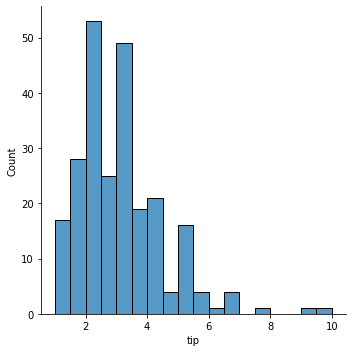

In [14]:
# ヒストグラムの描画
sns.displot(df['tip'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


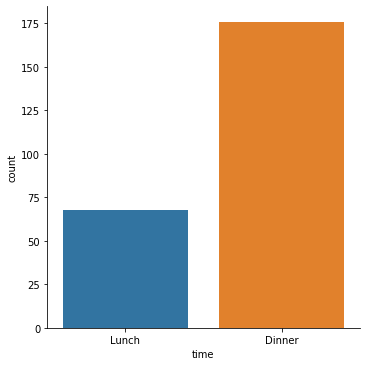

In [15]:
# 棒グラフの描画
sns.catplot('time', data=df, kind='count')

## ○平均値

In [17]:
np.mean([1, 2, 3])

2.0

In [20]:
# Seriesを渡すことも可能
np.mean(df['tip'])

2.9982786885245902

In [21]:
np.mean(df['tip_rate']) 

0.16080258172250478

In [23]:
df['tip_rate'].mean()

0.16080258172250478

In [24]:
# 性別ごとに平均値を見る
df.groupby("sex").mean()

,total_bill,tip,size,tip_rate
sex,,,,
Male,20.744076,3.089618,2.630573,0.157651
Female,18.056897,2.833448,2.459770,0.166491


<AxesSubplot:xlabel='sex', ylabel='tip_rate'>

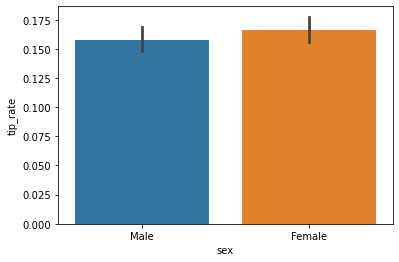

In [26]:
# カテゴリプロット
sns.barplot(x='sex', y='tip_rate', data=df)

何も指定しなくても平均が表示される。これはestimatorという引数のデフォルトがmean関数であるため。  
また、黒の縦棒はエラーバーを示す。消す場合はci=Noneを指定する。

<AxesSubplot:xlabel='sex'>

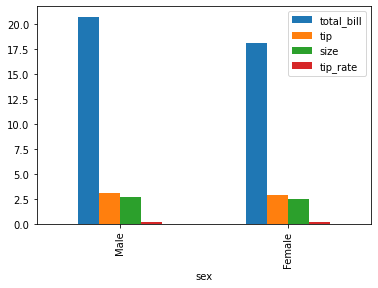

In [28]:
# Seriesから棒グラフを書く
df.groupby("sex").mean().plot(kind='bar')

## ○中央値

In [30]:
np.median([1, 3, 5])

3.0

In [33]:
np.median(df['tip_rate'])

0.15476977125802577

meanが16程度だったのに対してmedianが0.154なので、大きい方に外れ値があると予想される。

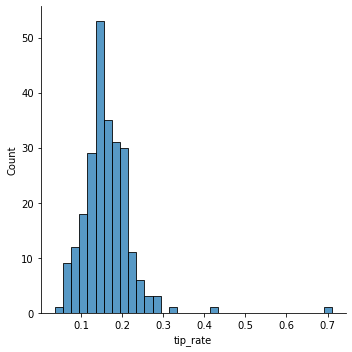

In [34]:
# 分布で確認
sns.displot(df['tip_rate'])

tip_rate=0.7の外れ値がいるので、meanはmedianに対して大きくなってしまう。

In [58]:
# DataFrame.median()でmedianを算出
df['tip_rate'].median()

0.15476977125802577

In [38]:
df.groupby('sex').median()

,total_bill,tip,size,tip_rate
sex,,,,
Male,18.35,3.00,2,0.153492
Female,16.40,2.75,2,0.155581


<AxesSubplot:xlabel='sex', ylabel='tip_rate'>

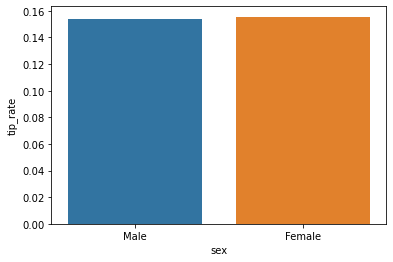

In [40]:
# medianを棒グラフで描画。estimatorにnp.medianを指定する
sns.barplot(x='sex', y='tip_rate', data=df, estimator=np.median, ci=None)

meanの場合と比較すると、Femaleはmedianの方が2%程低く、Maleとほぼ変わらない。  
これは、大きな外れ値があるため。

In [59]:
# 男性と女性ごとのtip_rateを降順に並べる。 
df.sort_values('tip_rate', ascending=False)

,total_bill,tip,sex,smoker,day,time,size,tip_rate
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
...,...,...,...,...,...,...,...,...
187,30.46,2.00,Male,Yes,Sun,Dinner,5,0.065660
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
57,26.41,1.50,Female,No,Sat,Dinner,2,0.056797
102,44.30,2.50,Female,Yes,Sat,Dinner,3,0.056433


## ○最頻値を求める
最頻値は下記で求める。科学計算用モジュールのScipy(サイパイ)を使用する。
* stats.mode() : 最頻値とカウントを返す。
* df['column'].mode() : 最頻値をSeriesで返す

In [47]:
stats.mode([1, 2, 2, 2, 3, 4])

ModeResult(mode=array([2]), count=array([3]))

In [50]:
# mode,countがndarrayで返される。それぞれ引数に入れる
mode, count = stats.mode([1, 2, 2, 2, 3, 4])

In [49]:
print(mode, count)

[2] [3]


In [53]:
# DFを入れる
mode, count = stats.mode(df)
df

,total_bill,tip,sex,smoker,day,time,size,tip_rate
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Male,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,Male,No,Sat,Dinner,2,0.098204


In [52]:
print(mode)
print(count)

[[13.42 2.0 'Male' 'No' 'Sat' 'Dinner' 2 0.1448225923244026]]
[[  3  33 157 151  87 176 156   2]]


DFの各カラムに対して、左から順にmode,countがarrayとして返される。  
上記だと、total_billのmodeは13.42でcountは3という意味になる。

In [57]:
# tip_rateカラムの最頻値をSeriesで返す
# 最頻値が複数ある（出てくる回数が同じ）場合のために、Seriesで帰ってくる
df['tip_rate'].mode()

0    0.144823
1    0.153846
dtype: float64

In [56]:
mode, count = stats.mode(df['size'])
print(mode, count)

[2] [156]


来客は二人組の場合が最も多く、156回ということが分かる

## ○範囲(range)

In [60]:
# 最小値を求める
np.min(df['tip'])

1.0

In [62]:
df['tip'].min()

1.0

In [63]:
df.groupby('sex').min()

,total_bill,tip,size,tip_rate
sex,,,,
Male,7.25,1.0,1,0.035638
Female,3.07,1.0,1,0.056433


In [64]:
# 最大値を求める
np.max(df['tip'])

10.0

In [65]:
df['tip'].max()

10.0

In [66]:
df.groupby('sex').max()

,total_bill,tip,size,tip_rate
sex,,,,
Male,50.81,10.0,6,0.710345
Female,44.30,6.5,6,0.416667


In [69]:
# 範囲を求める（あまり使うことはない）
np.max(df['tip']) - np.min(df['tip'])

9.0

## ○四分位数を求める 

In [75]:
# np.quantileで求める。これは四分位数ではなく分位数なので、25%,50%,75%を指定する必要がある。
# 任意の分位数を求めることができる
np.quantile(df['tip_rate'], [0.25, 0.5, 0.75])

array([0.12912736, 0.15476977, 0.19147549])

In [74]:
df['tip_rate'].quantile([0.25, 0.5, 0.75])

0.25    0.129127
0.50    0.154770
0.75    0.191475
Name: tip_rate, dtype: float64

In [76]:
# 四分位範囲をもとめる
stats.iqr(df['tip_rate'])

0.06234812458689151

In [77]:
0.191475 - 0.129127

0.062348000000000015

In [79]:
# 四分位偏差を求める
stats.iqr(df['tip_rate']) / 2

0.031174062293445756

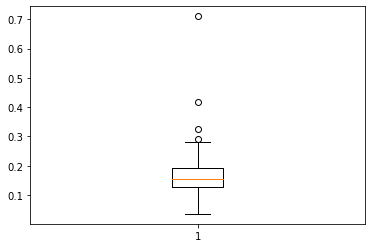

In [83]:
# 箱ひげ図も見てみる
plt.boxplot(df['tip_rate'])
plt.show()

ひげをどの範囲で書くかはケースバイケース。whis引数で指定できる。デフォルトではIQRの1.5倍。

<AxesSubplot:xlabel='size', ylabel='tip_rate'>

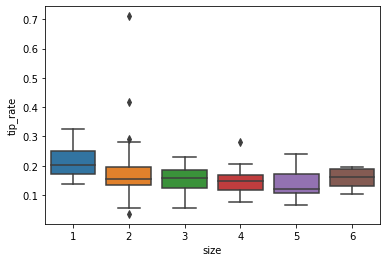

In [86]:
# seabornでboxplotを表示
sns.boxplot(x='size', y='tip_rate', data=df )

人数が多いほどtip_rateが下がる傾向にあることがわかる。  
これは人数が多いとtotal_billが上がるため、少人数の時のtip_rateと同じだと支払うチップ額が大きくなってしまうためセーブするからだと考えられる。

## ○分散と標準偏差

In [87]:
# np.var():分散を算出
np.var([1, 2, 3, 4])

1.25

In [88]:
np.var(df['tip_rate'])

0.0037145280013546928

In [89]:
# np.std():標準偏差を算出
np.std(df['tip'])

1.3807999538298958

In [91]:
np.mean(df['tip'])

2.9982786885245902

tip額の平均が約3,標準偏差が1.4ぐらいなので、仮に正規分布になっているなら  
68-95-99.7則に従い、tip額が1.6-4.4の間に全データの68%が入っていると予想される。

In [90]:
# varのルートをとると同じ。
np.sqrt(np.var(df['tip']))

1.3807999538298958